In [1]:
set(['DS', 'Productivity', 'DS', 'DS', 'Productivity', 'Productivity'])

{'DS', 'Productivity'}

# Evaluating Classifiers 

I found that the best way to go through an idea is to have an easy, low dimensional example so I can see the mechanics of whats going on. 

We're going to see that evaluating classifiers can be incredibly nuanced, and context dependant. Maybe you're building a model to see whether someone has a very rare form of cancer or just building a model to predict if someone likes football. The consequences of making mistakes and the distribution of our labels are DRASTICALLY different.

In [29]:
#the setup
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Context

The data we have is about a rare genetic disease. Very few people have it and our task is to build a machine learning model to figure out who has the disease and who doesn't.

nb: the model we build will be a very simple model, no feature engineering, no hyperparameter tuning, no cross validation. We are trying to see how to _evaluate_ classifiers! Maybe in the future i'll add a post with really involved modelling efforts

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter

In [31]:
def generate_data(w):
    #generate sample data and throw into dataframe
    data, labels= make_classification(
        n_samples = 1000, 
        n_features = 3, 
        n_informative=3,
        n_redundant=0,
        n_classes = 2, 
        weights=[w],
        random_state=42
        )
    data = np.append(data, labels.reshape(-1,1), axis = 1)
    
    return pd.DataFrame(data, columns = ['feature_0', 'feature_1', 'feature_2', 'target'])

In [32]:
def split_data(df):
    #split our data into train and test 
    train, test = train_test_split(df,
                test_size = 0.2,
                stratify = df['target'],
                random_state = 42)

    X_train, y_train = train.drop('target', axis = 1), train['target']

    X_test, y_test = test.drop('target', axis = 1), test['target']
    
    return X_train, X_test, y_train, y_test

In [33]:
def train_model(train, target):
    model = LogisticRegression()
    model.fit(train, target)
    return model

In [34]:
disease_df = generate_data(0.99)

In [35]:
X_train, X_test, y_train, y_test = split_data(disease_df)

In [36]:
#instantiate and fit our model
disease_model = train_model(X_train, y_train)

# Evaluating our model

So we've built our model, it might be rubbish and very crude right now but it exists only to server a purpose and not actually try and save someones life

In [37]:
#get the predictions for our test set
y_preds = disease_model.predict(X_test)

In [38]:
accuracy_score(y_test, y_preds)

0.985

## The problem with JUST accuracy

WOW! won't you look at that, we scored ~99% on our test set. That's all folks! go home, get on your linked in, call yourself a _dAtA sCiEnTisT_ and start applying for jobs! We crushed it! 

Alas if it were only that easy. 

A key skill you'll need in data science is skepticsim, if the results look too good, they probably are. A Healthy amount of skepticsim will get you far, especially if you start using it as a spidey sense for digging into things.

So lets have a look at our actual predictions

In [39]:
#Get a frequency count of our predictions
Counter(y_preds)

Counter({0.0: 200})

wait a second .. why are we never predicting that a patient has this super rare disease that's life threatening? something feels wrong here. 

Lets look at the definition of accuracy first

Accuracy = $\Large \frac{Number of correct Predictions}{Total number of predictions}$

A quick thought experiment: 

If our model was a child taking a test, whats the best way for this child to cheat on said test if the child was only being graded on accuracy and looking back at past papers over 99% of the answers were 0/False? 

Just Guess everything as 0/False! don't bother studying and spend that free time playing video games

But this isn't a child, its a statistical model and its predicting whether someone has a very rare life threatening illness so we can't accept this!

## different types of wrong errors



1. False Positive (type 1 error in the hypothesis testing context)
2. False Negative (type 2 error in the hypothesis testing context)

- (maybe ill write a separate article on hypothesis testing, A/B testing and bayesian A/B testing)

These errors sound like what they are, a False positive error, from here on will be referred to as FP is when we incorrectly classify a 0 as a 1, it's a _False_ _positive_ 

similarly a False Negative, from here on out will be reffered to as FN, is when you incorrectly classify a 1 as a 0 it's a _False_ _Negative_

### The confusion Matrix

The confusion matrix is an easy way to represent these four quantities, True Positive (TP), True Negative(TN), FP, FN

In [40]:
cm = pd.DataFrame(confusion_matrix(y_test, y_preds), 
             columns = ['Predicted False', 'Predicted True'],
            index = ['Actual False', 'Actual True'])
cm

,Predicted False,Predicted True
Actual False,197,0
Actual True,3,0


- top left cell is TN
- top right cell is FP
- bottom left cell is FN
- bottom right cell is TP

### Different error metrics 

Our confusion matrix is a nice segway into introducing other error metrics which we can use to evaluate our classifier. Depending on the context the cost of missclassifiying a positive sample might be really high. For example in our situation we really don't want to missclassify a positive sample just in case someone actually does have this very rare disease that could kill them. 

- **Precision**: Out of all the positive values we predicted how many were actually positive
    - $\large \frac{TP}{TP+FP}$


- **Recall**: Out of all the _actual_ positive values how many did we get right? 
    - $\large \frac{TP}{TP+FN}$
    
    
    
We can use these different metrics when trying to optimize performance over different situations but if you want a metric that evaluates the overall classifier in terms of precision and recall but don't necdesarily have a preference for one or the other you can look at your f1-score - the harmonic mean

- **f1-score**: Out of all the _actual_ positive values how many did we get right? 
    - $\large 2* \frac{Precision * Recall}{Precision+Recall}$

In [41]:
from sklearn.metrics import precision_score, recall_score

In [42]:
precision_score(y_test, y_preds)

0.0

In [43]:
recall_score(y_test, y_preds)

0.0

Wow. With these error metrics we did AWFULLY. Honestly, we didn't even predict any true values so they were always going to be rubbish. 

How can we deal with class imbalance? (I will not go over this in detail but will list out a few points and some links for you to follow)
- Random Over/Under Sampling of minority/majority class, respectfully

- More sophistacted Over/Under Sampling techniques based on point interpolation in the feature space to generate new synthetic samples, refer the to the imblearn package for many many different ways to sample: [https://imbalanced-learn.org/stable/](https://imbalanced-learn.org/stable/)

- Assigning different weights to the minority class - i.e telling our model, hey PAY ATTENTION TO THIS, ITS IMPORTANT!

### Moving Forward I will be slightly adjusting the context to illustrate different concepts in regards to evaluating classifiers

We are now Arsenal FC's head office, and want to predict season ticket holder churn. The president of the club has come to us, the data scientists to try and analyse data on our season ticket holders to predict who would churn and we want to make sure very few people actually leave.


In [44]:
football_df = generate_data(0.65)
X_train, X_test, y_train, y_test = split_data(football_df)

#instantiate and fit our model
football_model = train_model(X_train, y_train)

y_preds = football_model.predict(X_test)

accuracy_score(y_test, y_preds)

0.93

In [45]:
pd.DataFrame(confusion_matrix(y_test, y_preds), 
             columns = ['Predicted False', 'Predicted True'],
            index = ['Actual False', 'Actual True'])

,Predicted False,Predicted True
Actual False,126,4
Actual True,10,60


instead of calculating our confusion matrix, sklearn offers a clasification report function which calculates everything we would want to know

In [46]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       130
         1.0       0.94      0.86      0.90        70

    accuracy                           0.93       200
   macro avg       0.93      0.91      0.92       200
weighted avg       0.93      0.93      0.93       200



### Lets ROC n Roll
(If anyone's curious ROC stands for Receiver Operating Characteristic) 

In comes the roc graph which is a plot of the TPR and FPR

TPR = True Positive Rate = Recall = $\large \frac{TP}{TP+FN}$

FPR = False Positive Rate = $\large \frac{FP}{FP+TN}$
- Note: FPR is describing, out of all the negative samples we have how many of these are we _incorrectly_ guessing

Every point on the curve is a different classifier and below we'll look into how to interpret different points in the TPR/FPR space.

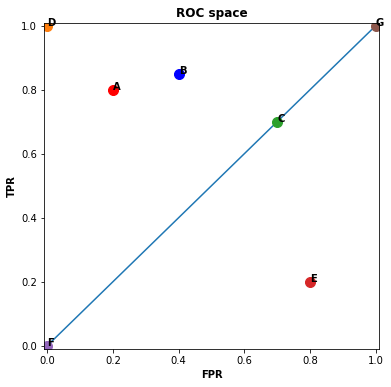

In [47]:
f, ax = plt.subplots(figsize=(6, 6))
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])

plt.plot(0,1, marker="o", markersize=10)
plt.annotate("D", (0,1), weight='bold')

plt.plot(0.2,0.8, marker="o", markersize=10, color = 'red')
plt.annotate("A", (0.2,0.8), weight='bold',)

plt.plot(0.4,0.85, marker="o", markersize=10,  color = 'blue')
plt.annotate("B", (0.4,0.85), weight='bold',)

plt.plot(0.7,0.7, marker="o", markersize=10)
plt.annotate("C", (0.7,0.7), weight='bold')

plt.plot(0.8,0.2, marker="o", markersize=10)
plt.annotate("E", (0.8,0.2), weight='bold')

plt.plot(0,0, marker="o", markersize=10)
plt.annotate("F", (0,0), weight='bold')

plt.plot(1,1, marker="o", markersize=10)
plt.annotate("G", (1,1), weight='bold')

plt.xlabel('FPR', weight = 'bold')
plt.ylabel('TPR', weight = 'bold')
plt.title('ROC space', weight = 'bold')

plt.show()

Each point above in the ROC space is a different classifier

- F @ (0,0): A model that never predicts the positive class so the classifier isn't "wrong" (FP) per say but it's never right (TP). 

- G @(1,1): A model that ONLY predicts the positive class

- D @ (0,1): The Perfect Classifier!

Classifiers to the left hand side of the graph are more conservative than classifiers to the right hand side which are more liberal

I.E Classifier A is more conservative than B meaning that it is less likely to predict a positive class than B.

- C @ (0.7, 0.7) is on the y=x line, this is saying that our classifier is as good as random guessing

- E @ (0.8,0.2) is in fact WORSE than random guessing and you should NEVER be below this diagonal line because well ... you can just inverse the prediction? 

Some further points to think about:
- Curves on the E side of the diagonal are said to use the data to predict in the wrong way
- Curves on the diagonal need to be given more data to predict properly
- Curves that are only slightly above the diagonal are they really better than random? or is it just a coincidence

### ROC CURVE

So what is the ROC curve that you've probably heard about?

Classifiers can either be **Discrete** or **Probabalistic**, A Discrete Classifier like our earlier example with the rare disease just predicts 1/0, True/False, you get it.

A probabalisitc classifier outputs some numeric score that represents an instances affinity to that class. The numeric score _COULD_ be a probability or some number such that if it above a threshold value we decide than that instance is part of the positive class

Varying this threshold value between 0 and 1 moves us from the conservative to liberal side but at each value of this threshold we can calculate the TPR and FPR of the classifier and plot it in the ROC space to get a ROC curve. The more points we plot the smoother the curve. We can find the threshold value that gives us the best classifier

### AUC

AUC stands for area under curve and it gives an idea of the expected performance of your classifier

The AUC of a classifier is also equivalent to the probability that the classifier will rank a randomly chosen positive instance higher than a randomly chosen negative instance. 

AUC's lie in the range of [0.5, 1] where 0.5 means we are essentially randomly guessing.

In Practice ROC curves summarise the **Trade off** between TPR and FPR for a model with different positive thresholds. You can think of it as a plot of false alarm rate against hit rate. They are a great for evaluating Balanced Classification problems (where the labels of 0/1 are more or less evenly distributed)

Text(0.5, 1.0, 'Football Model ROC-CURVE')

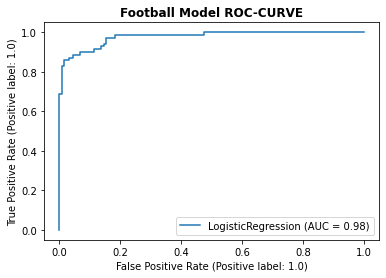

In [48]:
#we've talked about it enough but now lets actually plot it  

from sklearn.metrics import RocCurveDisplay

X_train, X_test, y_train, y_test = split_data(football_df)

RocCurveDisplay.from_estimator(football_model, X_test, y_test)
plt.title('Football Model ROC-CURVE', weight= 'bold')

Text(0.5, 1.0, 'Disease Model ROC-CURVE')

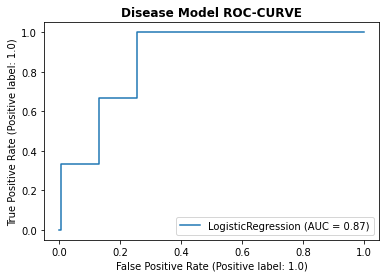

In [49]:
#Wow our football model is pretty good in terms of AUC and ROC
# Lets check out our disease model 

X_train, X_test, y_train, y_test = split_data(disease_df)

RocCurveDisplay.from_estimator(disease_model, X_test, y_test)
plt.title('Disease Model ROC-CURVE', weight= 'bold')

Wow the AUC's of these two separate classifiers are relatively similar. 0.87 definitely isn't a bad score for our  disease model but when we looked at our predictions they were awful... maybe AUC can be misleading in some cases? Especially in the imbalanced case. 

### Precision - Recall Curve


The Precision-Recall curve summarises the trade off between TPR = True Positive Rate = Recall and Positive Predicted Value = Precision at different thresholds

Lets look at the P-R Curve for our football and disease model

Text(0.5, 1.0, 'Football Model PR-CURVE')

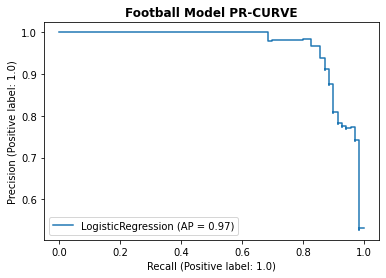

In [50]:
from sklearn.metrics import PrecisionRecallDisplay

X_train, X_test, y_train, y_test = split_data(football_df)

PrecisionRecallDisplay.from_estimator(football_model, X_test, y_test)
plt.title('Football Model PR-CURVE', weight= 'bold')

Text(0.5, 1.0, 'Disease Model PR-CURVE')

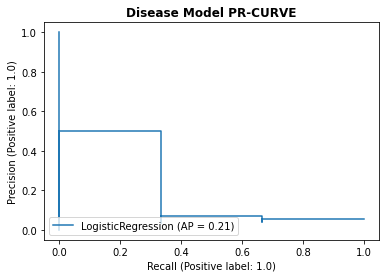

In [51]:
#The Disease Model

X_train, X_test, y_train, y_test = split_data(disease_df)

PrecisionRecallDisplay.from_estimator(disease_model, X_test, y_test)
plt.title('Disease Model PR-CURVE', weight= 'bold')

This Curve looks **HORRENDOUS** and makes more sense from the perspective that our disease model was a terrible model. 

### Good and Bad curve examples

In [111]:
np.arange(1,0, -0.01)

array([1.  , 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9 ,
       0.89, 0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8 , 0.79,
       0.78, 0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7 , 0.69, 0.68,
       0.67, 0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.6 , 0.59, 0.58, 0.57,
       0.56, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5 , 0.49, 0.48, 0.47, 0.46,
       0.45, 0.44, 0.43, 0.42, 0.41, 0.4 , 0.39, 0.38, 0.37, 0.36, 0.35,
       0.34, 0.33, 0.32, 0.31, 0.3 , 0.29, 0.28, 0.27, 0.26, 0.25, 0.24,
       0.23, 0.22, 0.21, 0.2 , 0.19, 0.18, 0.17, 0.16, 0.15, 0.14, 0.13,
       0.12, 0.11, 0.1 , 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02,
       0.01])

In [115]:
x_s = np.arange(0,1,0.01)
ideal_roc_y = [0] + [1 for x in range(len(x_s)-1)]
good_roc_y = [1-(x**10) for x in np.arange(1,0,-0.01)]

ideal_pr_y = [1 for x in range(len(x_s)-1)] + [0]
good_pr_y = [1-(x**10) for x in np.arange(0,1,0.01)]

def plot_curve_examples(y, ylab, xlab, title, ax, x=x_s):
    ax.plot(x, y)
    ax.set_title(title, weight = 'bold')
    ax.set_xlabel(xlab, weight = 'bold')
    ax.set_ylabel(ylab, weight = 'bold')

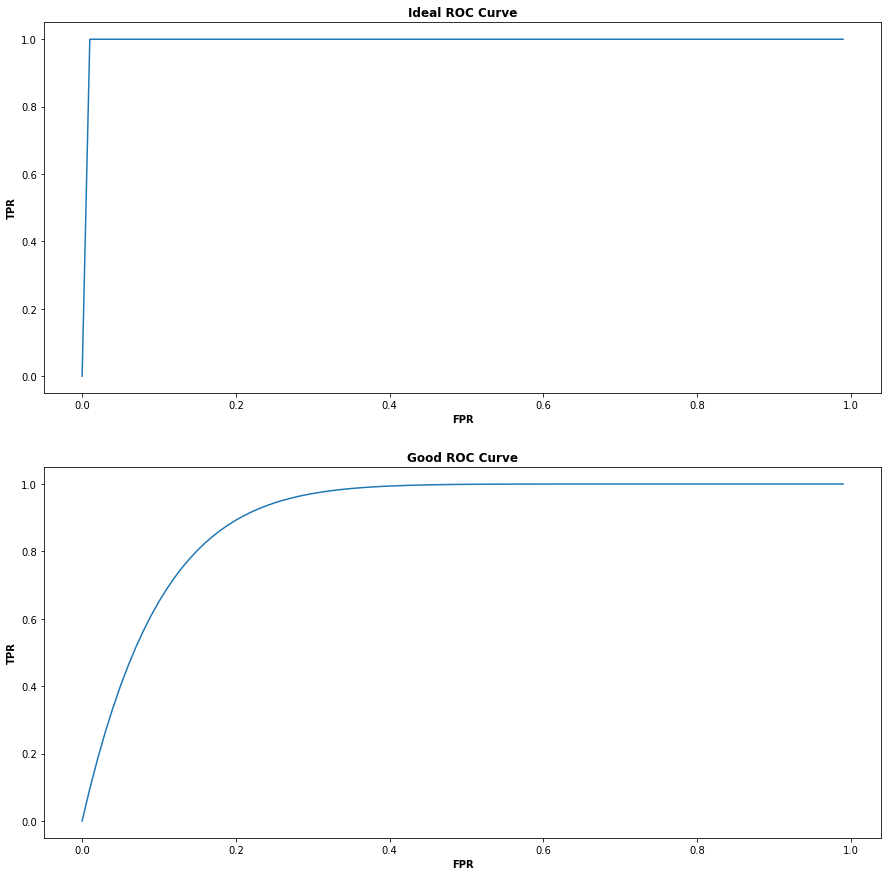

In [118]:
#The Ideal ROC 

plot_curve_examples(ideal_roc_y, 'TPR', 'FPR', 'Ideal ROC Curve', ax[0])
plot_curve_examples(good_roc_y, 'TPR', 'FPR', 'Good ROC Curve', ax[1])


### Why?

A Steep increase is what we are looking for in the ROC curve as this indicates that as we increase the threshold value to classify a sample as the positive class we get _MORE_ true positives than false positives

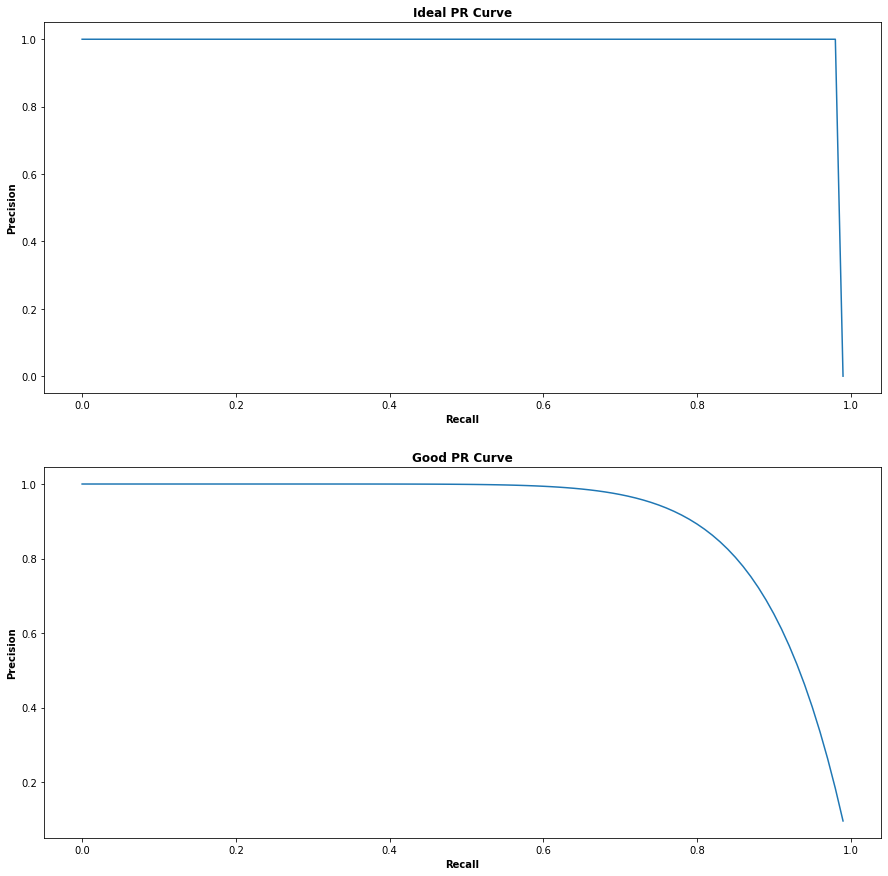

In [119]:
#Ideal PR Curves
fig, ax = plt.subplots(2, figsize=(15,15))
plot_curve_examples(ideal_pr_y, 'Precision', 'Recall', 'Ideal PR Curve', ax[0])
plot_curve_examples(good_pr_y, 'Precision', 'Recall', 'Good PR Curve', ax[1])

### Why?

A long horizontal line then a sharp decrease is what we are looking for because we would be increasing your recall without decreasing your precision

#### A Little note on the PR curve

The PR curve does not consider True Negatives and so should only be used when specificity is of NO concern

Specificity? ANOTHER METRIC? yeah lol theres a bunch of them

- **Specificty**: Out of all the _actual_ negative values how many did we get right? 
    - $\large \frac{TN}{TN+FP}$

# Further links to some videos/articles/references/chapters in books

- [Lots and Lots of different classification metrics and ways of combining TP,FP,FN,TN](https://en.wikipedia.org/wiki/Confusion_matrix)

- [Great video on imbalanced classification](https://www.youtube.com/watch?v=JvFrJacbt6U)

###### These articles are subject to revision because learning is a journey 